<a href="https://colab.research.google.com/github/Ayushi7877/credit-card-fraud-detection/blob/main/INT248.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from datetime import datetime 
from sklearn.metrics import roc_auc_score as auc 
import seaborn as sns

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


LOAD LIBRARIES


## **DATA** **EXPLORATION**

In [ ]:
df = pd.read_csv('/creditcard.csv.zip')

In [ ]:
df.shape

(284807, 31)

In [ ]:
print("Total time spanning: {:.1f} days".format(df['Time'].max() / (3600 * 24.0)))
print("{:.3f} % of all transactions are fraud. ".format(np.sum(df['Class']) / df.shape[0] * 100))

Total time spanning: 2.0 days
0.173 % of all transactions are fraud. 


In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

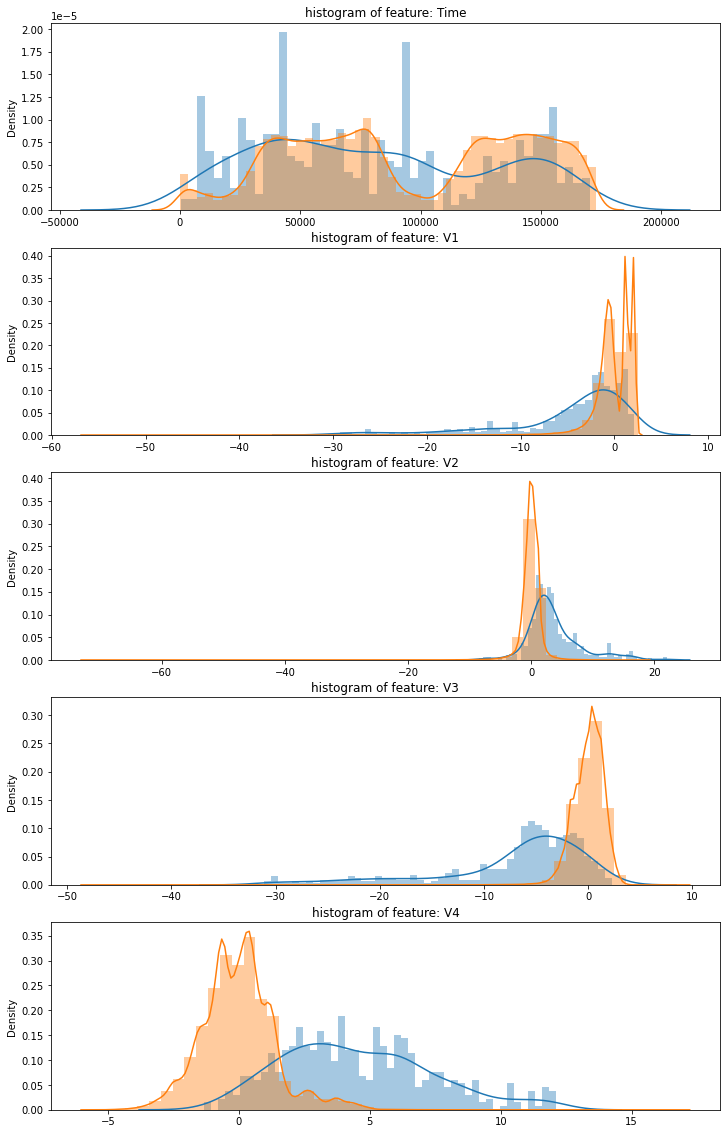

In [ ]:
plt.figure(figsize=(12,5*4))
gs = gridspec.GridSpec(5, 1)
for i, cn in enumerate(df.columns[:5]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

## Train and test split on time series, using first 75% as training/val, and last 25% as test

In [ ]:
TEST_RATIO = 0.25
df.sort_values('Time', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * df.shape[0])
train_x = df.iloc[:TRA_INDEX, 1:-2].values
train_y = df.iloc[:TRA_INDEX, -1].values

test_x = df.iloc[TRA_INDEX:, 1:-2].values
test_y = df.iloc[TRA_INDEX:, -1].values

In [ ]:
print("Total train examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(train_x.shape[0], np.sum(train_y), np.sum(train_y)/train_x.shape[0]))

Total train examples: 213605, total fraud cases: 398, equal to 0.00186 of total cases. 


In [ ]:
print("Total test examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(test_x.shape[0], np.sum(test_y), np.sum(test_y)/test_y.shape[0]))

Total test examples: 71202, total fraud cases: 94, equal to 0.00132 of total cases. 


## Feature Normalization - min max score (used for sigmoid activation)

In [ ]:
'''cols_max = []
cols_min = []
for c in range(train_x.shape[1]):
    cols_max.append(train_x[:,c].max())
    cols_min.append(train_x[:,c].min())
    train_x[:, c] = (train_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])
    test_x[:, c] =  (test_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])'''

'cols_max = []\ncols_min = []\nfor c in range(train_x.shape[1]):\n    cols_max.append(train_x[:,c].max())\n    cols_min.append(train_x[:,c].min())\n    train_x[:, c] = (train_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])\n    test_x[:, c] =  (test_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])'

## Feature Normalization 2 - z score (for tanh activation)

In [ ]:
cols_mean = []
cols_std = []
for c in range(train_x.shape[1]):
    cols_mean.append(train_x[:,c].mean())
    cols_std.append(train_x[:,c].std())
    train_x[:, c] = (train_x[:, c] - cols_mean[-1]) / cols_std[-1]
    test_x[:, c] =  (test_x[:, c] - cols_mean[-1]) / cols_std[-1]

### Modelling and results

## **1. Auto-encoder as unsupervised learning**

Parameters

In [ ]:
# Parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 256
display_step = 1

# Network Parameters
n_hidden_1 = 15 # 1st layer num features
#n_hidden_2 = 15 # 2nd layer num features
n_input = train_x.shape[1] # MNIST data input (img shape: 28*28)
data_dir = '.'

## Train and val the model - (1 hidden layer turned out to be enough)

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
X = tf.placeholder("float", [None, n_input])


weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    #'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    #'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    #'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
    #'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   #biases['encoder_b2']))
    return layer_1


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                  # biases['decoder_b2']))
    return layer_1

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define batch mse
batch_mse = tf.reduce_mean(tf.pow(y_true - y_pred, 2), 1)

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# TRAIN StARTS
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_x.shape[0], batch_size)
            batch_xs = train_x[batch_idx]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            train_batch_mse = sess.run(batch_mse, feed_dict={X: train_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Train auc=", "{:.6f}".format(auc(train_y, train_batch_mse)), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)
    

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch: 0001 cost= 1.535036325 Train auc= 0.953222 Time elapsed= 0:00:01.589273
Epoch: 0002 cost= 1.615391850 Train auc= 0.956277 Time elapsed= 0:00:02.598372
Epoch: 0003 cost= 0.625548244 Train auc= 0.958981 Time elapsed= 0:00:03.623559
Epoch: 0004 cost= 0.868392646 Train auc= 0.960852 Time elapsed= 0:00:04.636513
Epoch: 0005 cost= 0.736996770 Train auc= 0.958983 Time elapsed= 0:00:05.632334
Epoch: 0006 cost= 0.952557147 Train auc= 0.958237 Time elapsed= 0:00:06.641498
Epoch: 0007 cost= 0.432743043 Train auc= 0.957786 Time elapsed= 0:00:07.635274
Epoch: 0008 cost= 0.300035298 Train auc= 0.957246 Time elapsed= 0:00:08.641405
Epoch: 0009 cost= 0.550009131 Train auc= 0.956619 Time elapsed= 0:00:09.645271
Epoch: 0010 cost= 0.386720359 Train auc= 0.956637 Time elapsed= 0:00:10.655816
Optimiz

### Test model - on later 25% test data

In [ ]:
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_batch_mse = sess.run(batch_mse, feed_dict={X: test_x})
    
    print("Test auc score: {:.6f}".format(auc(test_y, test_batch_mse)))
    

INFO:tensorflow:Restoring parameters from ./temp_saved_model_1layer.ckpt
Test auc score: 0.944598


## Visualize the prediction

## 1. Display fraud score (mse) distribution for non-fraud cases

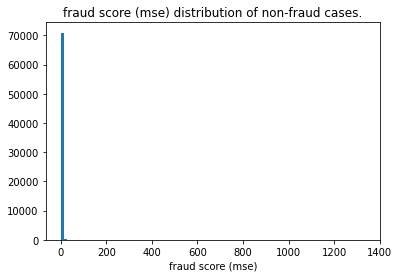

In [ ]:
plt.hist(test_batch_mse[test_y == 0.0], bins = 100)
plt.title("fraud score (mse) distribution of non-fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

## Zoom into (0, 20) range

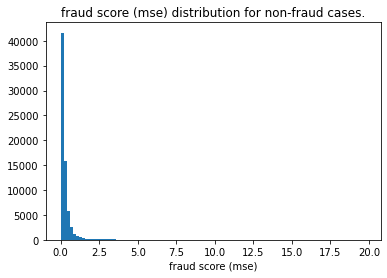

In [ ]:
plt.hist(test_batch_mse[(test_y == 0.0) & (test_batch_mse < 20)], bins = 100)
plt.title("fraud score (mse) distribution for non-fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

2. Display fraud score (mse) distribution for fraud cases

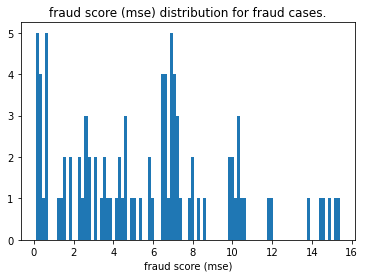

In [ ]:
plt.hist(test_batch_mse[test_y == 1.0], bins = 100)
plt.title("fraud score (mse) distribution for fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

In [ ]:

THRE_TEST = 7
print("Let's, for example, use 7 as our detection threshold: \n\
Number of detected cases above treshold: {}, \n\
Number of pos cases only above threshold: {}, \n\
The percentage of accuracy above treshold (Precision): {:0.2f}%. \n\
Compared to the average percentage of fraud in test set: 0.132%".format( \
np.sum(test_batch_mse > THRE_TEST), \
np.sum(test_y[test_batch_mse > THRE_TEST]), \
np.sum(test_y[test_batch_mse > THRE_TEST]) / np.sum(test_batch_mse > THRE_TEST) * 100))
      

Let's, for example, use 7 as our detection threshold: 
Number of detected cases above treshold: 501, 
Number of pos cases only above threshold: 31, 
The percentage of accuracy above treshold (Precision): 6.19%. 
Compared to the average percentage of fraud in test set: 0.132%


## Observation: Our precision increased by a factor of 60 from 0.132% to 7.86%; However, the detection precision is still low (below 8%), but this is mainly due to the overall percentage of fraud cases is really too low.

# 2. Build a binary classifier that predicts fraud, using the auto-encoder embedding layers as model inputs.

### 1) Get auto-encoder embedding (the encoder_op tensor) for both train and test data

In [35]:
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    saver.restore(sess, save_model)
    
    test_encoding = sess.run(encoder_op, feed_dict={X: test_x})
    train_encoding = sess.run(encoder_op, feed_dict={X: train_x})
    
    print("Dim for test_encoding and train_encoding are: \n", test_encoding.shape, '\n', train_encoding.shape)

INFO:tensorflow:Restoring parameters from ./temp_saved_model_1layer.ckpt
Dim for test_encoding and train_encoding are: 
 (71202, 15) 
 (213605, 15)


# 2) Build the graph for FC layers (best hidden size based on validation is found to be 4)

In [36]:
#n_input = test_encoding.shape[1]
n_input = test_encoding.shape[1]

hidden_size = 4
output_size = 2

X = tf.placeholder(tf.float32, [None, n_input], name='input_x')
y_ = tf.placeholder(tf.int32, shape=[None, output_size], name='target_y')

weights = {
    'W1': tf.Variable(tf.truncated_normal([n_input, hidden_size])),
    'W2': tf.Variable(tf.truncated_normal([hidden_size, output_size])),
}
biases = {
    'b1': tf.Variable(tf.zeros([hidden_size])),
    'b2': tf.Variable(tf.zeros([output_size])),
}

hidden_layer =  tf.nn.relu(tf.add(tf.matmul(X, weights['W1']), biases['b1']))
pred_logits = tf.add(tf.matmul(hidden_layer, weights['W2']), biases['b2'])
pred_probs = tf.nn.softmax(pred_logits)

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=pred_logits))

optimizer = tf.train.AdamOptimizer(2e-4).minimize(cross_entropy)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



3) Prepare the data set.
Now we need to re-split the train into train/val, due to supervised training.
We will therefore use 80% of out previous training data as our new training, and the remaining 20% as new validation. (train : val : test = (0.75x0.8) : (0.75x0.2) : (0.25x1.0)).
Finally we start to train our binary classifier

In [37]:
n_epochs = 80
batch_size = 256

# PREPARE DATA
VAL_PERC = 0.2
all_y_bin = np.zeros((df.shape[0], 2))
all_y_bin[range(df.shape[0]), df['Class'].values] = 1

train_enc_x = train_encoding[:int(train_encoding.shape[0] * (1-VAL_PERC))]
train_enc_y = all_y_bin[:int(train_encoding.shape[0] * (1-VAL_PERC))]

val_enc_x = train_encoding[int(train_encoding.shape[0] * (1-VAL_PERC)):]
val_enc_y = all_y_bin[int(train_encoding.shape[0] * (1-VAL_PERC)):train_encoding.shape[0]]

test_enc_y = all_y_bin[train_encoding.shape[0]:]
print("Num of data for train, val and test are: \n{}, \n{}, \n{}".format(train_enc_x.shape[0], val_enc_x.shape[0], \
                                                                        test_encoding.shape[0]))

# TRAIN STARTS
save_model = os.path.join(data_dir, 'temp_saved_model_FCLayers.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_enc_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(n_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_enc_x.shape[0], batch_size)
            batch_xs = train_enc_x[batch_idx]
            batch_ys = train_enc_y[batch_idx]

            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cross_entropy], feed_dict={X: batch_xs, y_: batch_ys})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            val_probs = sess.run(pred_probs, feed_dict={X: val_enc_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Val auc=", "{:.6f}".format(auc(val_enc_y[:, 1], val_probs[:, 1])), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)
    

Num of data for train, val and test are: 
170884, 
42721, 
71202
Epoch: 0001 cost= 2.423602104 Val auc= 0.754582 Time elapsed= 0:00:00.676279
Epoch: 0002 cost= 1.477531433 Val auc= 0.816868 Time elapsed= 0:00:01.274145
Epoch: 0003 cost= 0.883645296 Val auc= 0.849711 Time elapsed= 0:00:01.858782
Epoch: 0004 cost= 0.470491111 Val auc= 0.872589 Time elapsed= 0:00:02.437525
Epoch: 0005 cost= 0.268606275 Val auc= 0.887323 Time elapsed= 0:00:03.019144
Epoch: 0006 cost= 0.138299495 Val auc= 0.904871 Time elapsed= 0:00:03.609619
Epoch: 0007 cost= 0.109936155 Val auc= 0.916263 Time elapsed= 0:00:04.199546
Epoch: 0008 cost= 0.086402655 Val auc= 0.920993 Time elapsed= 0:00:04.788480
Epoch: 0009 cost= 0.055093028 Val auc= 0.927677 Time elapsed= 0:00:05.364926
Epoch: 0010 cost= 0.029247902 Val auc= 0.927265 Time elapsed= 0:00:05.949314
Epoch: 0011 cost= 0.014839947 Val auc= 0.924312 Time elapsed= 0:00:06.534973
Epoch: 0012 cost= 0.011028342 Val auc= 0.924993 Time elapsed= 0:00:07.134296
Epoch: 0013

# 4) Test the model on the same test data as before - improved on AUC slightly - 0.9669

In [38]:
n_epochs = 200
batch_size = 256

#n_input = test_encoding.shape[1]
n_input = train_x.shape[1]

hidden1_size = 8
hidden2_size = 4
output_size = 2

X = tf.placeholder(tf.float32, [None, n_input], name='input_x')
y_ = tf.placeholder(tf.int32, shape=[None, output_size], name='target_y')

weights = {
    'W1': tf.Variable(tf.truncated_normal([n_input, hidden1_size])),
    'W2': tf.Variable(tf.truncated_normal([hidden1_size, hidden2_size])),
    'W3': tf.Variable(tf.truncated_normal([hidden2_size, output_size])),
}
biases = {
    'b1': tf.Variable(tf.zeros([hidden1_size])),
    'b2': tf.Variable(tf.zeros([hidden2_size])),
    'b3': tf.Variable(tf.zeros([output_size])),
}

hidden1_layer =  tf.nn.relu(tf.add(tf.matmul(X, weights['W1']), biases['b1']))
hidden2_layer =  tf.nn.relu(tf.add(tf.matmul(hidden1_layer, weights['W2']), biases['b2']))
pred_logits = tf.add(tf.matmul(hidden2_layer, weights['W3']), biases['b3'])
pred_probs = tf.nn.softmax(pred_logits)

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=pred_logits))

optimizer = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)


2) Prepare the data set. Now we need to re-split the train into train/val.
## Again, we will use 80% of out previous training data as our new training, and the remaining 20% as new validation. (train : val : test = (0.75x0.8) : (0.75x0.2) : (0.25x1.0)).

In [39]:
# PREPARE DATA
VAL_PERC = 0.2
all_y_bin = np.zeros((df.shape[0], 2))
all_y_bin[range(df.shape[0]), df['Class'].values] = 1

train_enc_x = train_x[:int(train_x.shape[0] * (1-VAL_PERC))]
train_enc_y = all_y_bin[:int(train_x.shape[0] * (1-VAL_PERC))]

val_enc_x = train_x[int(train_encoding.shape[0] *  (1-VAL_PERC)):]
val_enc_y = all_y_bin[int(train_encoding.shape[0] * (1-VAL_PERC)):train_x.shape[0]]

test_enc_y = all_y_bin[train_x.shape[0]:]

print("Num of data for train, val and test are: \n{}, \n{}, \n{}".format(train_enc_x.shape[0], val_enc_x.shape[0], \
                                                                        test_encoding.shape[0]))
# TRAIN STARTS
save_model = os.path.join(data_dir, 'temp_saved_model_FCNNets_raw.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_enc_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(n_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_enc_x.shape[0], batch_size)
            batch_xs = train_enc_x[batch_idx]
            batch_ys = train_enc_y[batch_idx]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cross_entropy], feed_dict={X: batch_xs, y_: batch_ys})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            val_probs = sess.run(pred_probs, feed_dict={X: val_enc_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Val auc=", "{:.6f}".format(auc(val_enc_y[:, 1], val_probs[:, 1])), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)
    

Num of data for train, val and test are: 
170884, 
42721, 
71202
Epoch: 0001 cost= 0.436351269 Val auc= 0.640974 Time elapsed= 0:00:00.801424
Epoch: 0002 cost= 0.320638835 Val auc= 0.599564 Time elapsed= 0:00:01.499458
Epoch: 0003 cost= 0.270613849 Val auc= 0.546443 Time elapsed= 0:00:02.177758
Epoch: 0004 cost= 0.075970680 Val auc= 0.528417 Time elapsed= 0:00:02.874074
Epoch: 0005 cost= 0.010135699 Val auc= 0.528358 Time elapsed= 0:00:03.568296
Epoch: 0006 cost= 0.051712800 Val auc= 0.542099 Time elapsed= 0:00:04.258807
Epoch: 0007 cost= 0.011418036 Val auc= 0.583113 Time elapsed= 0:00:04.956745
Epoch: 0008 cost= 0.083799005 Val auc= 0.608005 Time elapsed= 0:00:05.637411
Epoch: 0009 cost= 0.003769101 Val auc= 0.634045 Time elapsed= 0:00:06.349647
Epoch: 0010 cost= 0.014052479 Val auc= 0.663681 Time elapsed= 0:00:07.031328
Epoch: 0011 cost= 0.020431899 Val auc= 0.686572 Time elapsed= 0:00:07.734584
Epoch: 0012 cost= 0.001565575 Val auc= 0.698199 Time elapsed= 0:00:08.422093
Epoch: 0013

## 3) Predict on test data

In [40]:
save_model = os.path.join(data_dir, 'temp_saved_model_FCNNets_raw.ckpt')
saver = tf.train.Saver()
# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_probs = sess.run(pred_probs, feed_dict={X: test_x})
    
    print("Test auc score: {}".format(auc(test_enc_y[:, 1], test_probs[:, 1])))

INFO:tensorflow:Restoring parameters from ./temp_saved_model_FCNNets_raw.ckpt
Test auc score: 0.9526415617119419
